In [1]:
from math import sqrt

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from lab1.src import (
    seed_everything,
    compute_pareto_mean,
    compute_pareto_variance,
    compute_theta
)
from lab3.src import (
    lscv_loss,
    smoothed_bootstrap_bandwidth,
    compute_knn_density,
    compare_densities,
    refined_plugin_bandwidth_selection,
)

seed_everything(42)

In [2]:
N = 6
S = 8
I1 = 5
I2 = 4

alpha_1 = 0.1
alpha_2 = 0.01

tau = 1 / (1 + I1)
p1 = (alpha_1 ** (1 - tau)) * (alpha_2 ** tau)
p2 = 5 * p1 / np.sqrt(S)

l = int((I2 + 2.5) / 2)

thetas = {
    1: (0, 1),
    2: (S, N),
    3: (N, S + 2),
    4: (S, S + N),
    5: (-N, S + 4),
}

pi_1 = S / (1 + I1 + 2 * N + S)
pi_2 = N / (1 + I1 + 2 * N + S)
pi_0 = 1 - pi_1 - pi_2

n_samples_1 = 100 * (2 + N)
n_samples_2 = 10 * (2 + N)
n_samples = n_samples_1

print(f"""
N = {N}
S = {S}
I1 = {I1}
I2 = {I2}
alpha_1 = {alpha_1}
alpha_2 = {alpha_2}
tau = {tau}
p1 = {p1}
p2 = {p2}
pi_1 = {pi_1}
pi_2 = {pi_2}
pi_0 = {pi_0}
l = {l}
n_samples = {n_samples}
thetas = {thetas}
""")


N = 6
S = 8
I1 = 5
I2 = 4
alpha_1 = 0.1
alpha_2 = 0.01
tau = 0.16666666666666666
p1 = 0.06812920690579613
p2 = 0.12043656049987451
pi_1 = 0.3076923076923077
pi_2 = 0.23076923076923078
pi_0 = 0.4615384615384615
l = 3
n_samples = 800
thetas = {1: (0, 1), 2: (8, 6), 3: (6, 10), 4: (8, 14), 5: (-6, 12)}



In [3]:
theta_0 = thetas[l]
mu0 = compute_pareto_mean(*theta_0)
v0 = compute_pareto_variance(*theta_0)

mu1 = mu0
v1 = N * v0

mu2 = mu0 + 2 * sqrt(v0)
v2 = v0 / S

theta_1 = compute_theta(mu1, v1)
theta_2 = compute_theta(mu2, v2)

print(f"""
theta_0 = {theta_0}
theta_1 = {theta_1}
theta_2 = {theta_2}
""")


theta_0 = (6, 10)
theta_1 = (5.273697218066576, 4.785938897200182)
theta_2 = (7.902231125466136, 31.971223758837382)



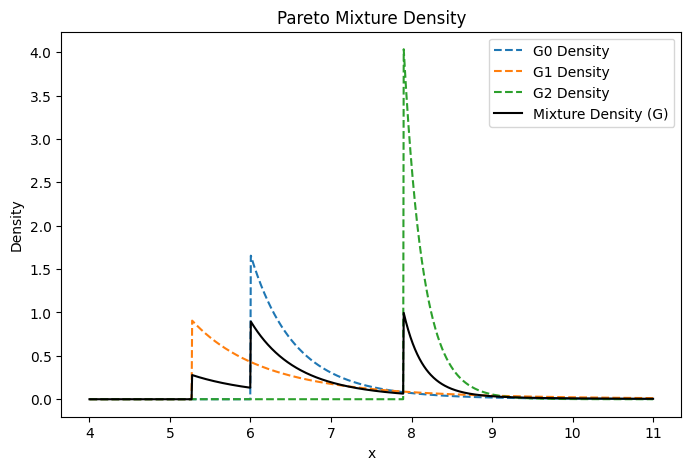

In [4]:
x_grid = np.linspace(4, 11, 1000)
G0_density = stats.pareto.pdf(x_grid, b=theta_0[1], scale=theta_0[0])
G1_density = stats.pareto.pdf(x_grid, b=theta_1[1], scale=theta_1[0])
G2_density = stats.pareto.pdf(x_grid, b=theta_2[1], scale=theta_2[0])
G_density = pi_0 * G0_density + pi_1 * G1_density + pi_2 * G2_density

plt.figure(figsize=(8, 5))
plt.plot(x_grid, G0_density, label="G0 Density", linestyle="--")
plt.plot(x_grid, G1_density, label="G1 Density", linestyle="--")
plt.plot(x_grid, G2_density, label="G2 Density", linestyle="--")
plt.plot(x_grid, G_density, label="Mixture Density (G)", color="black")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.title("Pareto Mixture Density")
plt.show()

Generated 800 samples from the Pareto mixture distribution.
Proportions: G0=0.46, G1=0.30, G2=0.24


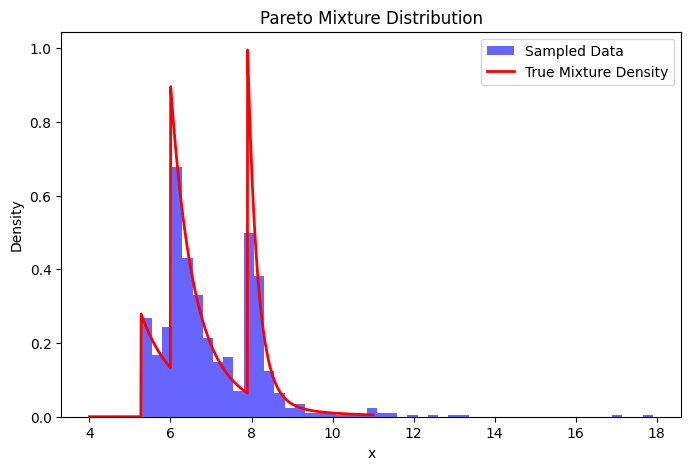

In [5]:
component_indices = np.random.choice([0, 1, 2], size=n_samples, p=[pi_0, pi_1, pi_2])

samples = np.zeros(n_samples)
samples[component_indices == 0] = stats.pareto.rvs(b=theta_0[1], scale=theta_0[0], size=(component_indices == 0).sum())
samples[component_indices == 1] = stats.pareto.rvs(b=theta_1[1], scale=theta_1[0], size=(component_indices == 1).sum())
samples[component_indices == 2] = stats.pareto.rvs(b=theta_2[1], scale=theta_2[0], size=(component_indices == 2).sum())

print(f"Generated {n_samples} samples from the Pareto mixture distribution.")

prop_0 = np.mean(component_indices == 0)
prop_1 = np.mean(component_indices == 1)
prop_2 = np.mean(component_indices == 2)

print(f"Proportions: G0={prop_0:.2f}, G1={prop_1:.2f}, G2={prop_2:.2f}")

plt.figure(figsize=(8, 5))
plt.hist(samples, bins=50, density=True, alpha=0.6, color="blue", label="Sampled Data")
plt.plot(x_grid, G_density, label="True Mixture Density", color="red", linewidth=2)
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.title("Pareto Mixture Distribution")
plt.show()

### Least Squared Cross-Validation

Optimal Bandwidth: 0.024387755102040817


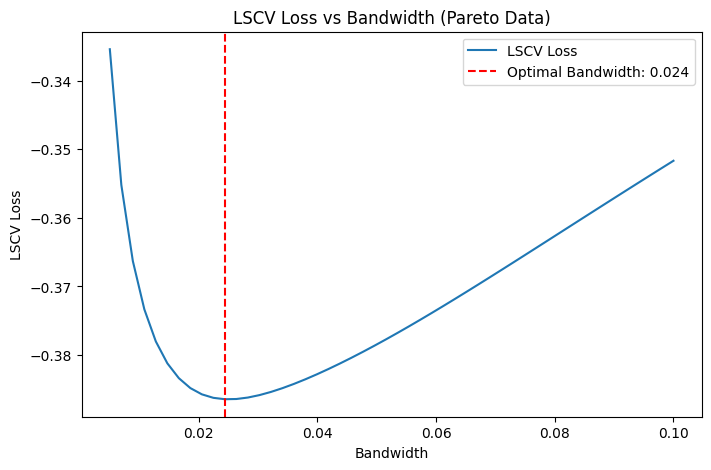

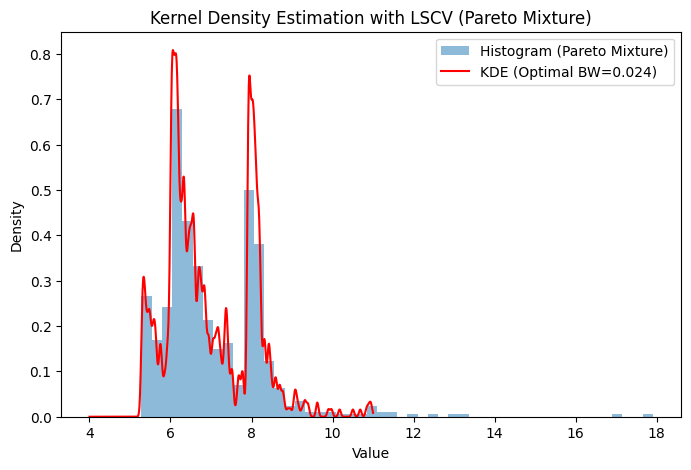

In [6]:
data = samples.copy()

bandwidths = np.linspace(0.005, 0.1, 50)
losses = [lscv_loss(data, bw.item()) for bw in bandwidths]
optimal_bw = bandwidths[np.argmin(losses)]
print(f"Optimal Bandwidth: {optimal_bw}")

plt.figure(figsize=(8, 5))
plt.plot(bandwidths, losses, label="LSCV Loss")
plt.axvline(optimal_bw, color="red", linestyle="--", label=f"Optimal Bandwidth: {optimal_bw:.3f}")
plt.xlabel("Bandwidth")
plt.ylabel("LSCV Loss")
plt.title("LSCV Loss vs Bandwidth (Pareto Data)")
plt.legend()
plt.show()

lscv_density = stats.gaussian_kde(data, bw_method=optimal_bw)(x_grid)

plt.figure(figsize=(8, 5))
plt.hist(data, bins=50, density=True, alpha=0.5, label="Histogram (Pareto Mixture)")
plt.plot(x_grid, lscv_density, label=f"KDE (Optimal BW={optimal_bw:.3f})", color="red")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Kernel Density Estimation with LSCV (Pareto Mixture)")
plt.legend()
plt.show()

### Refind Plug-in Method for Bandwidth Selection

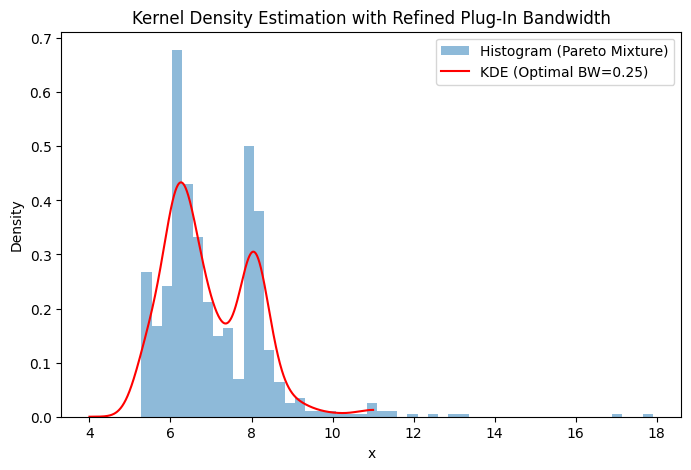

In [7]:
data = samples.copy()

optimal_bw = refined_plugin_bandwidth_selection(data)
plugin_density = stats.gaussian_kde(data, bw_method=optimal_bw)(x_grid)

plt.figure(figsize=(8, 5))
plt.hist(data, bins=50, density=True, alpha=0.5, label="Histogram (Pareto Mixture)")
plt.plot(x_grid, plugin_density, label=f"KDE (Optimal BW={optimal_bw:.2f})", color="red")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Kernel Density Estimation with Refined Plug-In Bandwidth")
plt.legend()
plt.show()

### Smoothed Bootstrap for Bandwidth Selection

Optimal Bandwidth: 0.005


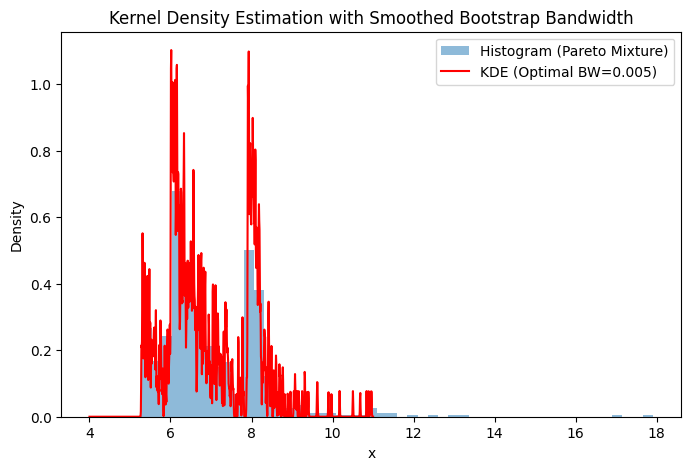

In [8]:
data = samples.copy()

bandwidths = np.linspace(0.005, 0.1, 50)
optimal_bw = smoothed_bootstrap_bandwidth(data, n_bootstrap=1, bandwidths=bandwidths)
print(f"Optimal Bandwidth: {optimal_bw}")

smoothed_bs_density = stats.gaussian_kde(data, bw_method=optimal_bw)(x_grid)

plt.figure(figsize=(8, 5))
plt.hist(data, bins=50, density=True, alpha=0.5, label="Histogram (Pareto Mixture)")
plt.plot(x_grid, smoothed_bs_density, label=f"KDE (Optimal BW={optimal_bw:.3f})", color="red")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Kernel Density Estimation with Smoothed Bootstrap Bandwidth")
plt.legend()
plt.show()

### k-Nearest Neighbours Density Estimator

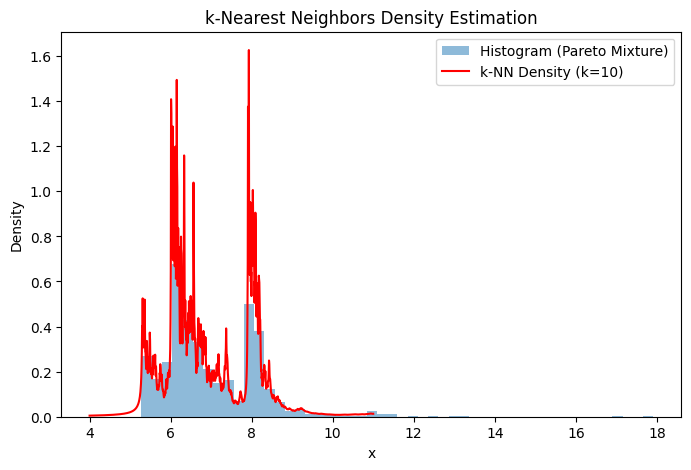

In [9]:
data = samples.copy()
k = 10
knn_density = compute_knn_density(data, x_grid, k)

plt.figure(figsize=(8, 5))
plt.hist(data, bins=50, density=True, alpha=0.5, label="Histogram (Pareto Mixture)")
plt.plot(x_grid, knn_density, label=f"k-NN Density (k={k})", color="red")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("k-Nearest Neighbors Density Estimation")
plt.legend()
plt.show()

### Comparison

In [11]:
compare_densities(
    true_density=G_density,
    estimated_densities=[lscv_density, plugin_density, smoothed_bs_density, knn_density],
    x_grid=x_grid,
    names=["LSCV", "Plugin", "Smoothed Bootstrap", "k-NN"]
)

Estimator           KS Statistic   KS p-value     ISE            Hellinger Distance  
--------------------------------------------------------------------------------
LSCV                0.225000       0.000000       0.019580       0.116019            
Plugin              0.222000       0.000000       0.094171       0.220558            
Smoothed Bootstrap  0.227000       0.000000       0.046387       0.203049            
k-NN                0.403000       0.000000       0.058230       0.160461            
